# Logistic Regression on German Credit Risk

### Our goal is to:
- Implement Logistic Regression with vanilla, l1 and l2 penalty.
- Impact on the coefficient of hypothesis because of lasso and ridge regression.
- Assess the different metrics on these different implementation of Logistic Regression.
- Evaluate False Positive Rate (FPR) on these models using Confusion Matrix.
- Visualize Receiver Operating Characteristics (ROC) curve and Precision-Recall curve to see the trend.

#### Suppressing any warnings

In [1]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Imports

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from colorsetup import colors, palette

### Read the data

In [2]:
#gcr_data = pd.read_csv("german_credit_data.csv", index_col=0)
#gcr_data = pd.read_csv("gcr_data_imputed2.csv")
gcr_data = pd.read_csv("gcr_data_imputed.csv")
#gcr_data = pd.read_csv("gcr_processed.csv")

In [3]:
gcr_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,4.219508,0.693147,2.0,1.386294,0.921956,1.000000,7.064759,1.945910,0.0,0.0,0.0,0.000000,0.000000,0.693147,0.0,0.0,1
1,3.135494,0.000000,2.0,1.386294,0.693147,2.000000,8.691483,3.891820,0.0,0.0,0.0,0.000000,0.000000,0.693147,0.0,0.0,0
2,3.912023,0.693147,1.0,1.386294,0.693147,1.693976,7.648263,2.564949,0.0,0.0,0.0,0.693147,0.000000,0.000000,0.0,0.0,1
3,3.828641,0.693147,2.0,0.693147,0.693147,1.000000,8.972464,3.761200,0.0,0.0,0.0,0.000000,0.693147,0.000000,0.0,0.0,1
4,3.988984,0.693147,2.0,0.693147,0.693147,1.000000,8.491055,3.218876,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0


In [8]:
gcr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1000 non-null   float64
 1   Sex                          1000 non-null   float64
 2   Job                          1000 non-null   float64
 3   Housing                      1000 non-null   float64
 4   Saving accounts              1000 non-null   float64
 5   Checking account             1000 non-null   float64
 6   Credit amount                1000 non-null   float64
 7   Duration                     1000 non-null   float64
 8   Purpose_business             1000 non-null   float64
 9   Purpose_car                  1000 non-null   float64
 10  Purpose_domestic appliances  1000 non-null   float64
 11  Purpose_education            1000 non-null   float64
 12  Purpose_furniture/equipment  1000 non-null   float64
 13  Purpose_radio/TV   

### Hyperparameter Optimization

In [4]:
#X = gcr_data.drop(['Risk','Credit_amount/duration'], axis=1)
#X = gcr_data.drop(['Risk', 'Credit_amount', 'Duration'], axis=1)
X = gcr_data.drop(['Risk'], axis=1)

y = gcr_data['Risk']

In [5]:
model_fi = ExtraTreesClassifier()
model_fi.fit(X,y)

feat_importances = pd.Series(model_fi.feature_importances_, index=X.columns)

In [6]:
X = gcr_data[feat_importances.nlargest(14).index]

In [7]:
X.head()

,Credit amount,Age,Duration,Checking account,Saving accounts,Job,Housing,Sex,Purpose_car,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_business,Purpose_education,Purpose_repairs
0,7.064759,4.219508,1.945910,1.000000,0.921956,2.0,1.386294,0.693147,0.0,0.000000,0.693147,0.0,0.000000,0.0
1,8.691483,3.135494,3.891820,2.000000,0.693147,2.0,1.386294,0.000000,0.0,0.000000,0.693147,0.0,0.000000,0.0
2,7.648263,3.912023,2.564949,1.693976,0.693147,1.0,1.386294,0.693147,0.0,0.000000,0.000000,0.0,0.693147,0.0
3,8.972464,3.828641,3.761200,1.000000,0.693147,2.0,0.693147,0.693147,0.0,0.693147,0.000000,0.0,0.000000,0.0
4,8.491055,3.988984,3.218876,1.000000,0.693147,2.0,0.693147,0.693147,1.0,0.000000,0.000000,0.0,0.000000,0.0


#### Random Search

In [15]:
from sklearn.linear_model import LogisticRegression

# define model
model = LogisticRegression()

In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

**n_splits: int, default=5**
    
Number of folds. Must be at least 2.

**n_repeats: int, default=10**

Number of times cross-validator needs to be repeated.

In [17]:
from scipy.stats import loguniform

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

**C: float, default=1.0**

Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

In [18]:
from sklearn.model_selection import RandomizedSearchCV

# we must set the number of iterations or samples to draw from the search space via the “n_iter” argument. In this case, we will set it to 500.

# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

In [19]:
# execute search
result = search.fit(X, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7476666666666666
Best Hyperparameters: {'C': 0.7447967465957297, 'penalty': 'l2', 'solver': 'newton-cg'}


#### Grid Search

In [260]:
from sklearn.model_selection import GridSearchCV

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

In [261]:
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

In [262]:
# execute search
result = search.fit(X, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.732
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


### Use the optimized hyperparameters model

#### StratifiedShuffleSplit

In [263]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data_imputed.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data_imputed.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data_imputed.loc[test_idx, 'Risk']

#### Model

In [264]:
lr_opt = LogisticRegression(C=0.1825, penalty='l2', solver='newton-cg').fit(X_train, y_train)

In [265]:
y_pred = lr_opt.predict(X_test)

In [266]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
# Preciision, recall, f-score from the multi-class support function
precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')

# The usual way to calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# ROC-AUC scores can be calculated by binarizing the data
auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
          label_binarize(y_pred, classes=[0,1]), 
          average='weighted')

# Last, the confusion matrix
cm = confusion_matrix(y_test, y_pred)

metrics = pd.Series({'precision':precision, 'recall':recall, 
                          'fscore':fscore, 'accuracy':accuracy,
                          'auc':auc})
metrics

precision    0.709319
recall       0.723333
fscore       0.656862
accuracy     0.723333
auc          0.561111
dtype: float64

### Confusion Matrix

FPR: 0.2857142857142857


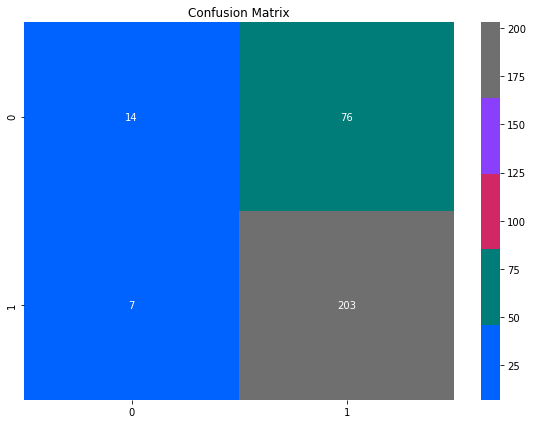

In [267]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8, 6)

sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap=colors);
ax.set(title='Confusion Matrix');
    
plt.tight_layout()